# Dependencies 

In [8]:
from sys import path
path.append('src/')

import numpy as np
import tensorflow as tf
import pickle as pkl
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, BatchNormalization, Activation
from keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, UpSampling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from skmultilearn.model_selection import iterative_train_test_split

In [2]:
FILE_TRAIN_DUMP = 'data/train_dump.pkl'
FILE_VAL_DUMP = 'data/val_dump.pkl'

FILE_MODEL = 'models/best_model.hdf5'

# Data Loading 

In [3]:
_, x_train, train_mrks = pkl.load(open(FILE_TRAIN_DUMP, 'rb'))
y_train = np.array([mrk_file.photo_reqs.values() for mrk_file in train_mrks])

print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)

(5211, 224, 224, 3) float32
(5211, 23) int32


In [4]:
_, x_val, val_mrks = pkl.load(open(FILE_VAL_DUMP, 'rb'))
y_val = np.array([mrk_file.photo_reqs.values() for mrk_file in val_mrks])

print(x_val.shape, x_val.dtype)
print(y_val.shape, y_val.dtype)

(571, 224, 224, 3) float32
(571, 23) int32


In [5]:
x = np.concatenate((x_train, x_val), axis=0)
y = np.concatenate((y_train, y_val), axis=0)

print(x.shape, y.shape)

(5782, 224, 224, 3) (5782, 23)


In [6]:
np.random.seed(42)
x_train, y_train, x_val, y_val = iterative_train_test_split(x, y, test_size=0.1)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(5188, 224, 224, 3) (5188, 23)
(594, 224, 224, 3) (594, 23)


In [7]:
pkl.dump((x_train, x_val), open('data/autoencoder_samples.pkl', 'wb'), -1)

# Model Training 

In [3]:
x_train, x_val = pkl.load(open('data/autoencoder_samples.pkl', 'rb'))
x_train /= 255.0
x_val /= 255.0

print(x_train.shape, x_train.dtype, x_train.min(), x_train.max())
print(x_val.shape, x_val.dtype, x_val.min(), x_val.max())

(5188, 224, 224, 3) float32 0.0 1.0
(594, 224, 224, 3) float32 0.0 1.0


In [5]:
def conv_bn(idx, prev_input, filters, name=None):
    conv_name = 'conv_' + str(idx)
    bn_name = 'bn_' + str(idx)
    act_name = 'relu_' + str(idx) if name is None else name
    
    conv = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=None, name=conv_name)(prev_input)
    conv = BatchNormalization(axis=-1, name=bn_name)(conv)
    conv = Activation('relu', name=act_name)(conv)
    return conv

def conv_bn_maxpool(idx, prev_input,  filters):
    pool_name = 'pool_' + str(idx)
    
    conv = conv_bn(idx, prev_input, filters)
    pool = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name=pool_name)(conv)
    return pool

def up_conv(idx, prev_input, filters, activation=None):
    up_name = str(idx) + '_up' 
    conv_name = str(idx) + '_conv' 
    
    deconv = UpSampling2D(size=(2, 2), name=up_name)(prev_input)
    deconv = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=activation, name=conv_name)(deconv)
    return deconv

def up_conv_bn(idx, prev_input, filters):
    up_name = str(idx) + '_up' 
    
    deconv = UpSampling2D(size=(2, 2), name=up_name)(prev_input)
    deconv = deconv_bn(idx, deconv, filters)
    return deconv

def deconv_bn(idx, prev_input, filters):
    bn_name = str(idx) + '_bn' 
    act_name = str(idx) + '_relu' 
    conv_name = str(idx) + '_conv' 
    
    deconv = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=None, name=conv_name)(prev_input)
    deconv = BatchNormalization(axis=-1, name=bn_name)(deconv)
    deconv = Activation('relu', name=act_name)(deconv)
    return deconv

In [7]:
inputs = Input(shape=x_train.shape[1:])
pool_1 = conv_bn_maxpool(1, inputs, 8)
pool_2 = conv_bn_maxpool(2, pool_1, 16)
pool_3 = conv_bn_maxpool(3, pool_2, 32)
pool_4 = conv_bn_maxpool(4, pool_3, 64)
encode = conv_bn(5, pool_4, 128, name='encoded')

dec_4 = deconv_bn(5, encode, 64)
dec_3 = up_conv_bn(4, dec_4, 32)
dec_2 = up_conv_bn(3, dec_3, 16)
dec_1 = up_conv_bn(2, dec_2, 8)
decoded = up_conv(1, dec_1, 3)

model = Model(inputs=inputs, outputs=decoded)
model.summary()

model.compile(optimizer='adam', loss='mean_squared_error')

list_callbacks = [ModelCheckpoint(FILE_MODEL, monitor='val_loss', verbose=1, save_best_only=True), 
                  EarlyStopping(monitor='val_loss', patience=10, verbose=1)]

hist = model.fit(x_train, x_train, batch_size=32, epochs=50, validation_data=(x_val, x_val), callbacks=list_callbacks)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 224, 224, 8)       224       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 224, 224, 8)       32        
_________________________________________________________________
relu_1 (Activation)          (None, 224, 224, 8)       0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 112, 112, 8)       0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 112, 112, 16)      1168      
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 112, 112, 16)      64        
__________

5188/5188 [==============================] - 10s 2ms/step - loss: 0.0051 - val_loss: 0.0061

Epoch 00016: val_loss improved from 0.00644 to 0.00606, saving model to models/best_model.hdf5
Epoch 17/50
5188/5188 [==============================] - 10s 2ms/step - loss: 0.0051 - val_loss: 0.0058

Epoch 00017: val_loss improved from 0.00606 to 0.00580, saving model to models/best_model.hdf5
Epoch 18/50
5188/5188 [==============================] - 10s 2ms/step - loss: 0.0050 - val_loss: 0.0054

Epoch 00018: val_loss improved from 0.00580 to 0.00544, saving model to models/best_model.hdf5
Epoch 19/50
5188/5188 [==============================] - 10s 2ms/step - loss: 0.0050 - val_loss: 0.0073A: 

Epoch 00019: val_loss did not improve from 0.00544
Epoch 20/50
5188/5188 [==============================] - 10s 2ms/step - loss: 0.0048 - val_loss: 0.0056

Epoch 00020: val_loss did not improve from 0.00544
Epoch 21/50
5188/5188 [==============================] - 10s 2ms/step - loss: 0.0047 - val_loss: 

In [9]:
model = load_model(FILE_MODEL)
y_pred = model.predict(x_val)

print(y_pred.shape, y_pred.dtype, y_pred.min(), y_pred.max())

(594, 224, 224, 3) float32 -0.07051021 1.292153


In [10]:
def normalize(im):
    min_im, max_im = im.min(), im.max()
    return ((im - min_im) / (max_im - min_im)) * 255

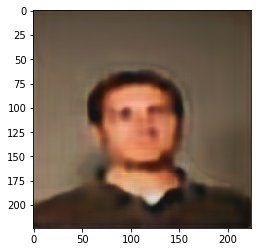

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

im = y_pred[np.random.choice(range(y_pred.shape[0]))]
im = normalize(im).astype(np.uint8)
plt.imshow(im[:, :, ::-1])